# Applied Data Science Capstone Final Assignment

# Gokhan Ince

# Suggesting a nice neighborhood in Kadikoy, Istanbul

## Table of contents
* [Introduction](#introduction)
* [Problem](#problem)
* [Data and Preparation](#dataprep)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Discussion and Results](#results)
* [Conclusion](#conclusion)

### Note: Github does not show the maps. If you want to see the project with the maps. Please go to:
### https://nbviewer.jupyter.org/github/incegokhan/Coursera_Capstone/blob/master/AppliedDataScienceCapstoneFinal.ipynb

## Introduction <a name="introduction"></a>

I am a data scientist in a consultancy company. My project targets the people who wants to move to Istanbul, Turkey. I will try to give them many suggestions based on their preferences and expectations. I will try to find them the neighborhoods that they can enjoy to live.

## Business Problem <a name="problem"></a>

Istanbul is a big city and it is very multicultural. In this project, i will focus on a client's need and  and try to find a good neighborhood where he can enjoy. But also, I will cluster the neighborhoods based on the venues they have. We will be able to suggest about which neighborhoods can make them happier. The neighborhoods should satisfy the needs of my clients. The clients who has different backgrounds would like live in a neighborhoods which can feel them comfortable. I should be able to give them suggestions to satify their needs.

My client Hans is currently living in Berlin, Germany. His company promoted him to be the general manager for one of their branch office. The company office is in Kadikoy, Istanbul. Hans wants to live close to the office and he prefers to live in Kadikoy. He is asking for our suggestions about neighborhoods. He wants to live in an enjoyable neighboorhood. He likes bars, pubs, restaurants etc. and we must give him the suggestions. Also, he wants to be close to public transportation like bus, metro and traing.

## Data and Preparation <a name="dataprep"></a>

I have some ideas about detecting the required data. First, i will detect the zip code, latitude and longitude values of the neighborhoods. I will convert and keep them in a dataframe. After that, I will use some loops to get information from Foursquare API by using the latitude and longitude information of the neighboorhoods. After that, i will merge those dataframes based on the postal codes. Then i will create new categories based on venue categories. At last, I will detect the client needs and then i will be able to suggest them neighborhoods to move based on their needs.

First, I will import the zip code, latitude and longitude information from a csv file. I got the infomrtion from the internet and converted to the csv format

To work with csv files, first i need to download pandas library.

In [1]:
import pandas as pd


And then pulled the data from the file.

In [3]:
kadikoy_df = pd.read_csv('kadikoypostalcodes.csv')

These are the first 5 rows of the data.

In [4]:
kadikoy_df.head()

,PostCode,Borough,Neighbourhood,Latitude,Longitude
0,34744,KADIKOY,BOSTANCI ...,40.957850,29.095760
1,34728,KADIKOY,CADDEBOSTAN ...,40.966740,29.062889
2,34710,KADIKOY,CAFERAGA ...,40.985741,29.024500
3,34722,KADIKOY,EGITIM ...,40.989441,29.049490
4,34722,KADIKOY,HASANPASA ...,40.996230,29.044650


Now let's pull the data from FourSquare. For that I will use neighboorhood's latitudes and longitudes.

In [5]:
CLIENT_ID='NJQUG3TFKKQ534FY1LDPXMMQA5PW0T1EDNHXL0IFT20FYDHJ' #Required for query
CLIENT_SECRET='D55WTVEONESDKAJ3JT1CRDU1QCWJRP4DZPUPJMIU0D10VNXH' #Required for query
VERSION='20190913' #Required for query
LIMIT = 500  #We will to pull 500 records. But we don't have a premium account. Because of that we can pull only 100
radius = 500 # Radius is 500 meters.

lat_df = [] # An empty data frame for latitude values
long_df = [] # An empty data frame for latitude values
lat_df= kadikoy_df['Latitude'] 
long_df=kadikoy_df['Longitude']
url_df = [] # # An empty data frame for URLs

Now i will create a while loop to get endpoints for each neighborhood.

In [6]:
i = 0
length = kadikoy_df.shape[0] # I need it for loop. I will get Foursquare URL for each neighborhood.
while i < length:
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat_df[i],
        long_df[i],
        radius, 
        LIMIT)
    url_df.append(url)
    i = i + 1

It is an example:

In [7]:
url_df[3]

'https://api.foursquare.com/v2/venues/explore?&client_id=NJQUG3TFKKQ534FY1LDPXMMQA5PW0T1EDNHXL0IFT20FYDHJ&client_secret=D55WTVEONESDKAJ3JT1CRDU1QCWJRP4DZPUPJMIU0D10VNXH&v=20190913&ll=40.989441,29.049490000000002&radius=500&limit=500'

It is a function to extract the categories of the venues.

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now, I will pull the data from Foursquare and export them to a csv file.

In [10]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

j = 0

while j < length:
    try:
        results = requests.get(url_df[j]).json()
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues)
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.distance']
        nearby_venues =nearby_venues.loc[:, filtered_columns]
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    except:
        pass
    nearby_venues['zipcode'] = kadikoy_df['PostCode'][j]
    nearby_venues['brgh'] = kadikoy_df['Borough'][j].replace(' ','')
    nearby_venues['nghbrhd'] = kadikoy_df['Neighbourhood'][j].replace(' ','')
    nearby_venues['centerlatitude'] = kadikoy_df['Latitude'][j]
    nearby_venues['centerlong'] = kadikoy_df['Longitude'][j]
    export_csv = nearby_venues.to_csv ('export_dataframe.csv', mode='a',encoding='utf-8',index = None, header=True)
    
    j = j+1

I will pull the data from exported csv file and create a new dataframe. Also, i will give new column names.

In [11]:
venue_data = pd.read_csv('export_dataframe.csv')

venue_data.columns = ['Name','Categories','Latitude','Longitude','Distance','Zip Code','Borough','Neighborhood','Center Latitude','Center Longitude']

It is the shape of the data. It has 1482 rows and 10 columns.

In [13]:
venue_data.shape

(1482, 10)

Some examples from the data...

In [14]:
venue_data.head(5)

,Name,Categories,Latitude,Longitude,Distance,Zip Code,Borough,Neighborhood,Center Latitude,Center Longitude
0,Safranbolu Fırını,Bakery,40.95879801089139,29.094185061159358,169,34744,KADIKOY,BOSTANCI,40.95785,29.09576
1,Bakıroğlu Gurme,Breakfast Spot,40.95776765987196,29.097471013753243,144,34744,KADIKOY,BOSTANCI,40.95785,29.09576
2,Dondurmacı Yaşar Usta,Ice Cream Shop,40.9571934765289,29.09702105815656,128,34744,KADIKOY,BOSTANCI,40.95785,29.09576
3,Studyo pilates,Athletics & Sports,40.95801339918345,29.09609239972061,33,34744,KADIKOY,BOSTANCI,40.95785,29.09576
4,Ekler İstanbul Bostancı,Dessert Shop,40.95770450717472,29.096905420764813,97,34744,KADIKOY,BOSTANCI,40.95785,29.09576


I will create a new dataframe to filter the data. I will pull only bars, pubs, clubs, discos, nigh clubs and transportation venues.

In [15]:
filtered_venue_df = pd.DataFrame()
filtered_venue_df = venue_data[venue_data['Categories'].isin(['Bar','Pub','Club','Disco','Nightclub','Metro Station','Bus Station','Train Station'])]

Some examples from the data...

In [16]:
filtered_venue_df.head()

,Name,Categories,Latitude,Longitude,Distance,Zip Code,Borough,Neighborhood,Center Latitude,Center Longitude
25,1A Meyhanesi,Bar,40.95515138179538,29.09469130467661,313,34744,KADIKOY,BOSTANCI,40.95785,29.09576
35,Bostancı Marmaray İstasyonu,Train Station,40.95383652588117,29.094997878388686,451,34744,KADIKOY,BOSTANCI,40.95785,29.09576
40,Anatolia Turku Evi,Bar,40.95390940436293,29.09375427889648,469,34744,KADIKOY,BOSTANCI,40.95785,29.09576
44,Cadde Bostancı,Nightclub,40.95411230848213,29.093504120757636,457,34744,KADIKOY,BOSTANCI,40.95785,29.09576
48,Train Gar,Pub,40.95337925547904,29.09514623904152,500,34744,KADIKOY,BOSTANCI,40.95785,29.09576


## Methodology  <a name="methodology"></a>

In this project I will use FourSquare data, analyze it and try to get meaningful results. The venues will be within 500 meters to the neighborhood centers.
In first step, I pulled the data from Forsquare and matched them with neighborhood data. Also, i created some filtered dataframes. There is a purpose for each dataframe.
In second step, I will start to analyze the data. I will try to get the most popular venue categories, frequency, filtering with desired venue types and then visualizing them.
I will also, show the findings on a map.
ın third step, I will cluster the neighborhoods by using the most popular venue types and frequencies in the neighborhood, detect the clusters and show them on a map. Wish me luck.

## Analysis  <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. We can count the venues in the neighborhoods and decide that which of them are better for Hans.

### Detecting the venue categories and the number in the neighborhoods.

We can detect the number of venues in neighbourhoods.

In [17]:
venue_data.groupby(['Categories'])['Neighborhood'].value_counts().sort_values(ascending=False)

Categories          Neighborhood
Café                CAFERAGA        28
                    OSMANAGA        25
                    RASIMPASA       23
categories          nghbrhd         20
Café                FENERYOLU       14
                                    ..
Library             CADDEBOSTAN      1
Lawyer              KOZYATAGI        1
Kokoreç Restaurant  DUMLUPINAR       1
                    BOSTANCI         1
Accessories Store   FENERBAHCE       1
Name: Neighborhood, Length: 793, dtype: int64

Now, let's show the venues numbers for each categories in neighborhoods

In [18]:
filtered_venue_df.groupby(['Neighborhood'])['Categories'].value_counts()

Neighborhood  Categories   
ACIBADEM      Bar              2
              Pub              1
BOSTANCI      Bar              3
              Nightclub        3
              Pub              2
              Train Station    1
CADDEBOSTAN   Bar              3
              Nightclub        3
CAFERAGA      Bar              3
              Pub              3
EGITIM        Pub              1
ERENKOY       Train Station    1
FENERBAHCE    Pub              2
              Bar              1
FENERYOLU     Train Station    1
GOZTEPE       Train Station    1
HASANPASA     Bus Station      1
              Nightclub        1
KOSUYOLU      Bar              1
              Pub              1
MERDIVENKOY   Bus Station      1
OSMANAGA      Bar              6
              Pub              5
              Nightclub        1
SUADIYE       Pub              2
              Bar              1
ZUHTUPASA     Nightclub        3
              Pub              2
              Bar              1
Name: Categorie

### Visualizing the findings

We can also visualize it. We can show our findings on a horizontal bar plot

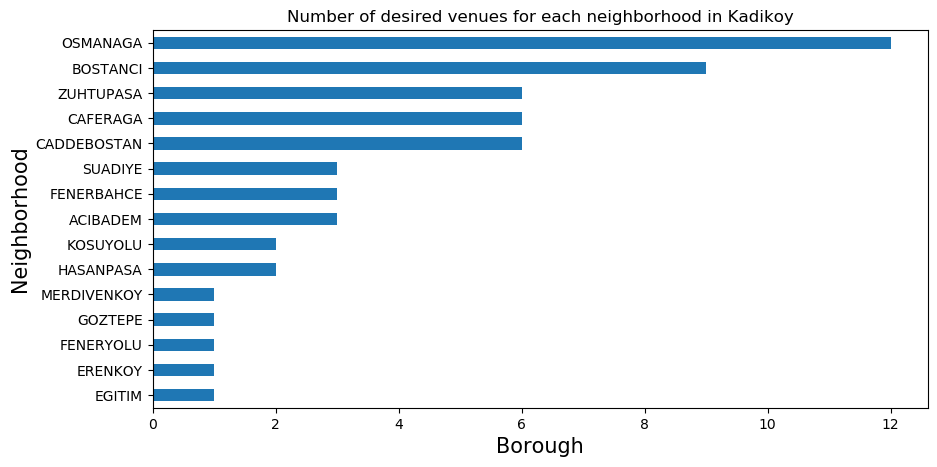

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5), dpi = 100)
# Title of the plot
plt.title('Number of desired venues for each neighborhood in Kadikoy')
# Y axis label and fontize
plt.xlabel('Borough', fontsize = 15)
# Y axis label and fontize
plt.ylabel('Number of Venues', fontsize=15)
#giving a bar plot
filtered_venue_df.groupby(['Neighborhood'])['Zip Code'].count().sort_values(ascending=True).plot(kind='barh')
#legend
#displays the plot
plt.show()



### Showing the desired venues on a map

Now, we can show the venues on a map to be sure about our analysis.We need to import Folium library to show our venues on the map.

In [21]:
!pip install folium
import pandas as pd
import folium

Now, we should prepare the query to get a map.

In [22]:
map_kadikoy = folium.Map(location=[40.9903, 29.0205], zoom_start=13)
# added markers to map
for lat, lng, borough, Neighbourhood in zip(filtered_venue_df['Latitude'], filtered_venue_df['Longitude'], filtered_venue_df['Borough'], filtered_venue_df['Neighborhood']):
    label = '{}, {}'.format(Neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kadikoy)

Our map at last! We can see that Osmanaga neighborhood is the best option for our client.

In [23]:
map_kadikoy

### One-hot encoding

Now, I will use one-hot encoding to detect the frequencies.

In [24]:
kd_venue_category_onehot = pd.get_dummies(venue_data[['Categories']])
kd_venue_category_onehot['Neighborhood'] = venue_data['Neighborhood']
fix_columns = kd_venue_category_onehot.columns[-1] + kd_venue_category_onehot.columns[:-1]
#kd_venue_category_onehot = kd_venue_category_onehot[fix_columns]
print(kd_venue_category_onehot.shape)
venue_c = kd_venue_category_onehot.groupby('Neighborhood').sum()

venue_c.drop(venue_c.tail(1).index,inplace=True)
print('Dataframe shape: ' , venue_c.shape)

(1482, 225)
Dataframe shape:  (21, 224)


It is the result with sum up.

In [25]:
venue_c

,Categories_Accessories Store,Categories_Advertising Agency,Categories_African Restaurant,Categories_Arcade,Categories_Art Gallery,Categories_Arts & Crafts Store,Categories_Asian Restaurant,Categories_Athletics & Sports,Categories_Auto Dealership,Categories_Automotive Shop,...,Categories_Volleyball Court,Categories_Water Park,Categories_Waterfront,Categories_Wine Bar,Categories_Wine Shop,Categories_Winery,Categories_Wings Joint,Categories_Women's Store,Categories_Yoga Studio,Categories_categories
Neighborhood,,,,,,,,,,,,,,,,,,,,,
19MAYIS,0,0,0,0,2,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
ACIBADEM,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
BOSTANCI,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,2,0
CADDEBOSTAN,0,0,0,0,0,1,0,2,0,0,...,0,0,1,0,0,0,1,0,2,0
CAFERAGA,0,0,0,0,2,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
DUMLUPINAR,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EGITIM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ERENKOY,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FENERBAHCE,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


### Grouping the neighborhoods by frequency

Now, we can group the neighborhoods by frequency. I created a new dataframe by using one-hot encoding.

In [26]:
kadikoy_grouped = kd_venue_category_onehot.groupby('Neighborhood').mean().reset_index()

### 5 most common venue categories

I will print the neighborhoods with the 5 most common venues.

In [27]:
# Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in kadikoy_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kadikoy_grouped[kadikoy_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----19MAYIS----
                           venue  freq
0              Categories_Bakery  0.10
1                Categories_Café  0.09
2                Categories_Park  0.08
3                 Categories_Gym  0.04
4  Categories_Turkish Restaurant  0.04


----ACIBADEM----
                         venue  freq
0              Categories_Café  0.17
1    Categories_Breakfast Spot  0.05
2      Categories_Dessert Shop  0.05
3  Categories_Kebab Restaurant  0.05
4      Categories_Burger Joint  0.05


----BOSTANCI----
                     venue  freq
0          Categories_Café  0.08
1    Categories_Restaurant  0.06
2   Categories_Coffee Shop  0.05
3  Categories_Dessert Shop  0.04
4     Categories_Nightclub  0.04


----CADDEBOSTAN----
                           venue  freq
0         Categories_Coffee Shop  0.14
1                Categories_Café  0.07
2  Categories_Seafood Restaurant  0.06
3          Categories_Restaurant  0.06
4      Categories_Ice Cream Shop  0.04


----CAFERAGA----
                 

It is a function to get most common venues.

In [28]:
# Let's put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most popular 10 venue categories in each neighborhood

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [29]:
import numpy as np
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kadikoy_grouped['Neighborhood']

for ind in np.arange(kadikoy_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kadikoy_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,19MAYIS,Categories_Bakery,Categories_Café,Categories_Park,Categories_Furniture / Home Store,Categories_Gym,Categories_Turkish Restaurant,Categories_Convenience Store,Categories_Clothing Store,Categories_Coffee Shop,Categories_Bistro
1,ACIBADEM,Categories_Café,Categories_Turkish Restaurant,Categories_Breakfast Spot,Categories_Burger Joint,Categories_Kebab Restaurant,Categories_Dessert Shop,Categories_Bar,Categories_Coffee Shop,Categories_Pub,Categories_Lounge
2,BOSTANCI,Categories_Café,Categories_Restaurant,Categories_Coffee Shop,Categories_Nightclub,Categories_Dessert Shop,Categories_Music Venue,Categories_Bar,Categories_Pet Store,Categories_Seafood Restaurant,Categories_Bakery
3,CADDEBOSTAN,Categories_Coffee Shop,Categories_Café,Categories_Restaurant,Categories_Seafood Restaurant,Categories_Ice Cream Shop,Categories_Salon / Barbershop,Categories_Cosmetics Shop,Categories_Bar,Categories_Nightclub,Categories_Bookstore
4,CAFERAGA,Categories_Café,Categories_Coffee Shop,Categories_Dessert Shop,Categories_Pub,Categories_Theater,Categories_Chocolate Shop,Categories_Bar,Categories_Pizza Place,Categories_Italian Restaurant,Categories_Ice Cream Shop
5,DUMLUPINAR,Categories_Café,Categories_Fast Food Restaurant,Categories_Park,Categories_Gym / Fitness Center,Categories_Bakery,Categories_Department Store,Categories_Grocery Store,Categories_Steakhouse,Categories_Martial Arts Dojo,Categories_Restaurant
6,EGITIM,Categories_Café,Categories_Grocery Store,Categories_Bakery,Categories_Restaurant,Categories_Flower Shop,Categories_Nail Salon,Categories_Cigkofte Place,Categories_Borek Place,Categories_Scenic Lookout,Categories_Coffee Shop
7,ERENKOY,Categories_Bakery,Categories_Dessert Shop,Categories_Turkish Restaurant,Categories_Coffee Shop,Categories_Café,Categories_Gym,Categories_Doner Restaurant,Categories_Boutique,Categories_Fast Food Restaurant,Categories_Martial Arts Dojo
8,FENERBAHCE,Categories_Restaurant,Categories_Café,Categories_Seafood Restaurant,Categories_Dessert Shop,Categories_Kebab Restaurant,Categories_Steakhouse,Categories_Gym / Fitness Center,Categories_Department Store,Categories_Music Venue,Categories_Coffee Shop
9,FENERYOLU,Categories_Café,Categories_Coffee Shop,Categories_Restaurant,Categories_Fast Food Restaurant,Categories_Kebab Restaurant,Categories_Park,Categories_Pizza Place,Categories_Cosmetics Shop,Categories_Burger Joint,Categories_Gym


I will drop the rows which has name "nghbrhd"

In [30]:
kadikoy_grouped = kadikoy_grouped[kadikoy_grouped.Neighborhood != 'nghbrhd']
neighborhoods_venues_sorted = neighborhoods_venues_sorted[neighborhoods_venues_sorted.Neighborhood != 'nghbrhd']

### Clustering the neighboorhoods

Now, we can start to cluster the neighborhoods. First let's import the library and then do the clustering

In [31]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

kadikoy_grouped_clustering = kadikoy_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kadikoy_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 0, 0, 1, 4, 4, 4, 0, 1])

I will change he column names. It will be required to merge the dataframes. One dataframe has "Neighbourhood" column, other one has "Neighborhood"

In [32]:
kadikoy_df.columns = ['Postcode','Borough','Neighborhood','Latitude','Longitude']

Now, I need to sort the dataframe. Because I will use the index to match the dataframe rows.

In [33]:
df_sorted = kadikoy_df.sort_values(by='Neighborhood').reset_index()

### Adding cluster labels to the dataframe

Now, I will add the cluster labels to the dataframe. It will be the last column.

In [34]:
merged_kadikoy = neighborhoods_venues_sorted.merge(df_sorted, left_index=True, right_index=True)
merged_kadikoy['Cluster Labels'] = kmeans.labels_

In [35]:
merged_kadikoy

,Neighborhood_x,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,index,Postcode,Borough,Neighborhood_y,Latitude,Longitude,Cluster Labels
0,19MAYIS,Categories_Bakery,Categories_Café,Categories_Park,Categories_Furniture / Home Store,Categories_Gym,Categories_Turkish Restaurant,Categories_Convenience Store,Categories_Clothing Store,Categories_Coffee Shop,Categories_Bistro,16,34736,KADIKOY,19 MAYIS ...,40.973510,29.088960,4
1,ACIBADEM,Categories_Café,Categories_Turkish Restaurant,Categories_Breakfast Spot,Categories_Burger Joint,Categories_Kebab Restaurant,Categories_Dessert Shop,Categories_Bar,Categories_Coffee Shop,Categories_Pub,Categories_Lounge,12,34718,KADIKOY,ACIBADEM ...,41.001780,29.038740,4
2,BOSTANCI,Categories_Café,Categories_Restaurant,Categories_Coffee Shop,Categories_Nightclub,Categories_Dessert Shop,Categories_Music Venue,Categories_Bar,Categories_Pet Store,Categories_Seafood Restaurant,Categories_Bakery,0,34744,KADIKOY,BOSTANCI ...,40.957850,29.095760,0
3,CADDEBOSTAN,Categories_Coffee Shop,Categories_Café,Categories_Restaurant,Categories_Seafood Restaurant,Categories_Ice Cream Shop,Categories_Salon / Barbershop,Categories_Cosmetics Shop,Categories_Bar,Categories_Nightclub,Categories_Bookstore,1,34728,KADIKOY,CADDEBOSTAN ...,40.966740,29.062889,0
4,CAFERAGA,Categories_Café,Categories_Coffee Shop,Categories_Dessert Shop,Categories_Pub,Categories_Theater,Categories_Chocolate Shop,Categories_Bar,Categories_Pizza Place,Categories_Italian Restaurant,Categories_Ice Cream Shop,2,34710,KADIKOY,CAFERAGA ...,40.985741,29.024500,1
5,DUMLUPINAR,Categories_Café,Categories_Fast Food Restaurant,Categories_Park,Categories_Gym / Fitness Center,Categories_Bakery,Categories_Department Store,Categories_Grocery Store,Categories_Steakhouse,Categories_Martial Arts Dojo,Categories_Restaurant,9,34720,KADIKOY,DUMLUPINAR ...,40.992630,29.060530,4
6,EGITIM,Categories_Café,Categories_Grocery Store,Categories_Bakery,Categories_Restaurant,Categories_Flower Shop,Categories_Nail Salon,Categories_Cigkofte Place,Categories_Borek Place,Categories_Scenic Lookout,Categories_Coffee Shop,3,34722,KADIKOY,EGITIM ...,40.989441,29.049490,4
7,ERENKOY,Categories_Bakery,Categories_Dessert Shop,Categories_Turkish Restaurant,Categories_Coffee Shop,Categories_Café,Categories_Gym,Categories_Doner Restaurant,Categories_Boutique,Categories_Fast Food Restaurant,Categories_Martial Arts Dojo,5,34738,KADIKOY,ERENKOY ...,40.972880,29.075440,4
8,FENERBAHCE,Categories_Restaurant,Categories_Café,Categories_Seafood Restaurant,Categories_Dessert Shop,Categories_Kebab Restaurant,Categories_Steakhouse,Categories_Gym / Fitness Center,Categories_Department Store,Categories_Music Venue,Categories_Coffee Shop,6,34726,KADIKOY,FENERBAHCE ...,40.974450,29.043540,0
9,FENERYOLU,Categories_Café,Categories_Coffee Shop,Categories_Restaurant,Categories_Fast Food Restaurant,Categories_Kebab Restaurant,Categories_Park,Categories_Pizza Place,Categories_Cosmetics Shop,Categories_Burger Joint,Categories_Gym,7,34724,KADIKOY,FENERYOLU ...,40.982010,29.049550,1


### Showing the clustered neighborhoods on a map

Now, it is the most exciting moment. We will be able to see the clustered neighborhoods on the map

In [36]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_kadikoy_clustered = folium.Map(location=[40.9903, 29.0205], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_kadikoy['Latitude'], merged_kadikoy['Longitude'], merged_kadikoy['Neighborhood_x'], merged_kadikoy['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_kadikoy_clustered)
       
map_kadikoy_clustered

## Discussion and Results <a name="results"></a>

Now, let's discuss about the issue and results. I had to analyze the neighborhoods in Kadikoy and detect what kind of venues these neighborhoods have. After that i should group them based on client needs. Different kind of people wants to be close to different type of places. I need to detect their needs and find the perfect neighborhoods for them to satisfy their needs. 

First, I detected latitude and longitude information of the neighborhoods. After that I used FourSquare API to pull the venue to the neighborhoods closer than 500 meters.Then, I used some filters to detect the best neighborhood for my client. My client already told us that he likes to be close to bars, pubs, restaurant and the entertainment venues. So, we should suggest the neighborhoods that can satisfy his needs. Then I used one-hot encoding to detect the frequency of the venues. I detected 10 most popular venue categories in the neighborhoods. I used K-means clustering to cluster the neighborhoods and used Folium library to show them on a map. I detected 5 clusters. 

My analysis shows that Osmanaga is the best neighbourhood in Kadikoy for our client. There are many entertainment venues around. Hans can find many places like bars, pubs, restaurants etc. But also, Rasimpasa, Caferaga, Feneryolu and Merdivenkoy can be good for him. These neighborhoods are also in the same cluster.

## Conclusion <a name="conclusion"></a>

Purpose of the project was to suggest the best neighbourhood for our client. In order to do it, I clustered the neighborhoods by using FourSquare data. This data helped me to cluster the neighborhoods.

I detected that Osmanaga is the best neighborhood for the client. But also, we can suggest him Rasimpasa and Caferaga neighborhoods. They are in the same clusters.

As a final decision, we will offer him to move to Osmanaga and give Rasimaga and Caferaga neighborhoods as alternative suggestions.